In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## MALAI Challenge - Dots and Boxes

In [Dots and Boxes](https://en.wikipedia.org/wiki/Dots_and_boxes) two players alternately draw short horizontal or vertical lines on a grid.
When a player completes a box, they get another turn. 

Passing is not allowed.

The game ends when all possible lines have been draw. The player who has completed
the most boxes wins.

The game is very simple to play but hard to play well!

---------

Your challenge should you choose to accept it, is to write a robot that plays Dots and Boxes.

A robot is a Python function that takes a `board` and makes a `move`.

We will explain both these concept below. 

In [2]:
from board import Board
from draw import drawboard

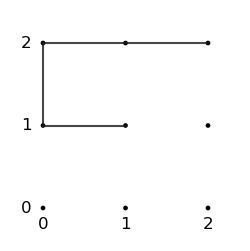

In [3]:
board = Board(size=2, lines=[(0, 1, 1, 1), (0, 1, 0, 2), (0, 2, 1, 2), (1, 2, 2, 2)], red_boxes=[], blue_boxes=[])
drawboard(board,size=3)

size  --> number of boxes in each row and column. Total boxes = size*size

lines --> lines on the board. each line (i,j,r,s) goes from (i,j) to (r,s)

We use the convention that i<=j and r<=s so lines go rightwards and upwards

Let's make a move! A move is a list of one or more lines.

In [7]:
from board import makemove, isvalidmove
move = [(1,0,1,1)]
board2 = makemove(board, move, 0)

In [8]:
isvalidmove(board, move)

True

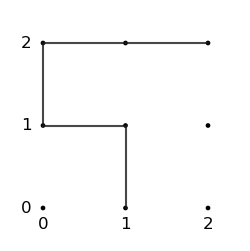

In [9]:
drawboard(board2, 3)

Let's make another move!

In [10]:
move = [(1,1,1,2)]
isvalidmove(board, move)

False

Why is this move invalid?

In [11]:
from board import getnewboxes

getnewboxes(board.lines, move[0])

[(0, 1)]

When you make a box, you have to make another move, and so on till either 

1. Your line does not make a box
2. The game ends

Remember: No passing.

In [13]:
move = [(1,1,1,2), (1,0,1,2)]
board3 = makemove(board2, move, 1)

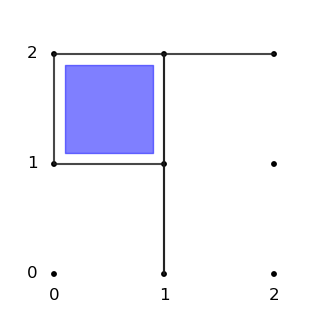

In [14]:
drawboard(board3)

Red = Player 0 moves first.

Blue = Player 1 moves second.

## A very simple robot

The simplest strategy is to draw a line at random.

Check it makes a box. If so, draw another line at random...

That's it.

In [16]:
import random
from typing import List
from board import get_all_lines, Line

def make_random_move(board:Board)->List[Line]:
    n = board.size
    #All lines have already been made
    if len(board.lines) >= 2*n*(n+1):
        return []
    
    options = [l for l in get_all_lines(n) if l not in board.lines]
    line = random.choice(options)
    move = [line]
    options.remove(line)

    #As long as the line makes a box and is not the last line,
    #make another line
    while options and getnewboxes(board.lines+move[:-1], line):
        line = random.choice(options)
        move += [line]
        options.remove(line)

    if not isvalidmove(board, move):
        print("Oops",board,move)

    return move

#### Let's play random vs random. 

In [18]:
b = Board(size=2, lines=[])
board_list = [b]
m = make_random_move(b)
player = 0
while m:
    print(b,m)
    b = makemove(b,m,("red","blue")[player])
    board_list += [b]
    m = make_random_move(b)
    player = 1-player

Board(size=2, lines=[], red_boxes=[], blue_boxes=[]) [(2, 1, 2, 2)]
Board(size=2, lines=[(2, 1, 2, 2)], red_boxes=[], blue_boxes=[]) [(0, 1, 0, 2)]
Board(size=2, lines=[(2, 1, 2, 2), (0, 1, 0, 2)], red_boxes=[], blue_boxes=[]) [(0, 0, 0, 1)]
Board(size=2, lines=[(2, 1, 2, 2), (0, 1, 0, 2), (0, 0, 0, 1)], red_boxes=[], blue_boxes=[]) [(0, 0, 1, 0)]
Board(size=2, lines=[(2, 1, 2, 2), (0, 1, 0, 2), (0, 0, 0, 1), (0, 0, 1, 0)], red_boxes=[], blue_boxes=[]) [(1, 2, 2, 2)]
Board(size=2, lines=[(2, 1, 2, 2), (0, 1, 0, 2), (0, 0, 0, 1), (0, 0, 1, 0), (1, 2, 2, 2)], red_boxes=[], blue_boxes=[]) [(1, 1, 2, 1)]
Board(size=2, lines=[(2, 1, 2, 2), (0, 1, 0, 2), (0, 0, 0, 1), (0, 0, 1, 0), (1, 2, 2, 2), (1, 1, 2, 1)], red_boxes=[], blue_boxes=[]) [(0, 1, 1, 1)]
Board(size=2, lines=[(2, 1, 2, 2), (0, 1, 0, 2), (0, 0, 0, 1), (0, 0, 1, 0), (1, 2, 2, 2), (1, 1, 2, 1), (0, 1, 1, 1)], red_boxes=[], blue_boxes=[]) [(2, 0, 2, 1)]
Board(size=2, lines=[(2, 1, 2, 2), (0, 1, 0, 2), (0, 0, 0, 1), (0, 0, 1, 0), (

In [165]:
def getboxes(board:Board)->List[Tuple[int,int]]:
    """
    Returns list of the bottom-left corners of all filled boxes.  
    """
    lines = board.lines
    boxes = []
    for i in range(board.size):
        for j in range(board.size):
            if (i,j,i+1,j) in lines and\
               (i,j+1,i+1,j+1) in lines and\
               (i,j,i,j+1) in lines and\
               (i+1,j,i+1,j+1) in lines:
                boxes.append((i,j)) 
               
    return boxes


def countboxes(board:Board)->int:
    """
    Returns number of filled boxes on the board.
    """
    return len(getboxes(board))


def isboxfilled(board:Board, box:Tuple[int,int])->bool:
    """
    Given the bottom-left corner of a box, check if it is filled (all lines are 
    on the board).
    """
    lines = board.lines
    i,j = box
    return (i,j,i+1,j) in lines and (i,j+1,i+1,j+1) in lines and\
            (i,j,i,j+1) in lines and (i+1,j,i+1,j+1) in lines


def getnewboxes(lines:List[Line], line:Line)->List[Tuple[int]]:
    """
    Returns list of NEW boxes created by adding one NEW *line* to the *lines* 
    that have already been drawn. 
    Boxes are denoted by the bottom-left corner.
    """
    if line in lines:
        return []

    i,j,r,s = line

    above = [(i,j+1,i+1,j+1), (i,j,i,j+1), (i+1,j,i+1,j+1)]
    below = [(i,j-1,i,j), (i,j-1,i+1,j-1), (i+1,j-1,i+1,j)]
    right = [(i,j+1,i+1,j+1), (i,j,i+1,j), (i+1,j,i+1,j+1)]
    left  = [(i-1,j,i,j), (i-1,j,i-1,j+1), (i-1,j+1,i,j+1)]
    
    options = ()
    if r-i == 1:
        options = ((above, (i,j)), 
                   (below, (i,j-1)))
    elif s-j == 1:
        options = ((right, (i,j)),
                   (left,  (i-1,j))) 

    newboxes = [box for (remaining, box) in options if all((l in lines for l in remaining))]
    return newboxes


In [161]:
def isvalidmove(board:Board, move:List[Line])->bool:
    """
    Checks validity of a move. A move is a list of lines made a player
    in his/her turn.

    If a line creates a filled box then there must a next line and so on, 
    until either no box is created or the game ends.
    """
    n = board.size
    #A move can be empty iff there are no more lines to made
    if not move and len(board.lines) < 2*n*(n+1):
        return False
    #No repeated lines 
    if any((line in board.lines for line in move)) or\
        len(set(move)) != len(move):
            return False
    
    #Each of the lines in the move before the last one, must add a new box
    total_lines = list(board.lines) + move
    for i in range(len(board.lines), len(total_lines)-1):
        if not getnewboxes(total_lines[:i], total_lines[i]):
            return False
    
    #The last line must either:
    #   1. Be the last line of the game
    #   2. NOT create a new box
    if len(total_lines) < 2*n*(n+1) and getnewboxes(total_lines[:-1], move[-1]):
        return False
    
    return True

In [92]:
from copy import copy

def makemove(board:Board, move:List[Line], player:Literal["red","blue"], 
             copyboard=True, checkmove=True)->Board:
    """
    Make a move i.e. add its line(s) to the board.
    Returns a new board or changes board directly based on *copyboard*.
    """
    if copyboard:
        board = copy(board)
    if checkmove and not isvalidmove(board, move):
        print(f"Invalid {move} for {board}")
        return board
    
    old_boxes = getboxes(board)
    board.lines += move
    new_boxes = getboxes(board)
    added_boxes = [b for b in new_boxes if b not in old_boxes]
    if player == "red":
        board.red_boxes += added_boxes
    else:
        board.blue_boxes += added_boxes
    
    return board

In [166]:
def get_all_lines(n:int)->List[Line]:
    """
    Returns list of all 2n(n+1) lines possible on an n X n board.
    """
    all_lines = [(i,j,i+1,j) for i in range(n) for j in range(n)]
    all_lines += [(i,j,i,j+1) for i in range(n) for j in range(n)]
    all_lines += [(n,i,n,i+1) for i in range(n)]
    all_lines += [(i,n,i+1,n) for i in range(n)]
    
    all_lines = [(min(i,r),min(j,s),max(i,r),max(j,s)) for (i,j,r,s) in all_lines]
    return all_lines

In [19]:
import random

def make_random_move(board:Board)->List[Line]:
    n = board.size
    #All lines have already been made
    if len(board.lines) >= 2*n*(n+1):
        return []
    
    options = [l for l in get_all_lines(n) if l not in board.lines]
    line = random.choice(options)
    move = [line]
    options.remove(line)

    #As long as the line makes a box and is not the last line,
    #make another line
    while options and getnewboxes(board.lines+move[:-1], line):
        line = random.choice(options)
        move += [line]
        options.remove(line)

    if not isvalidmove(board, move):
        print("Oops",board,move)

    return move

In [152]:
b = Board(size=2)
board_list = [b]
m = make_random_move(b)
player = 0
while m:
    print(b,m)
    b = makemove(b,m,("red","blue")[player])
    board_list += [b]
    m = make_random_move(b)
    player = 1-player
    

Board(size=2, lines=[], red_boxes=[], blue_boxes=[]) [(1, 1, 1, 2)]
Board(size=2, lines=[(1, 1, 1, 2)], red_boxes=[], blue_boxes=[]) [(2, 1, 2, 2)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2)], red_boxes=[], blue_boxes=[]) [(1, 1, 2, 1)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1)], red_boxes=[], blue_boxes=[]) [(1, 0, 1, 1)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1)], red_boxes=[], blue_boxes=[]) [(0, 0, 1, 0)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1), (0, 0, 1, 0)], red_boxes=[], blue_boxes=[]) [(0, 1, 1, 1)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1), (0, 0, 1, 0), (0, 1, 1, 1)], red_boxes=[], blue_boxes=[]) [(0, 1, 0, 2)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (1, 0, 1, 1), (0, 0, 1, 0), (0, 1, 1, 1), (0, 1, 0, 2)], red_boxes=[], blue_boxes=[]) [(0, 0, 0, 1), (1, 0, 2, 0)]
Board(size=2, lines=[(1, 1, 1, 2), (2, 1, 2, 2), (1, 1, 2, 1), (

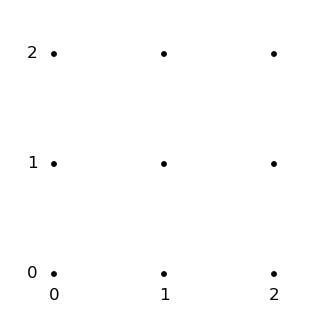

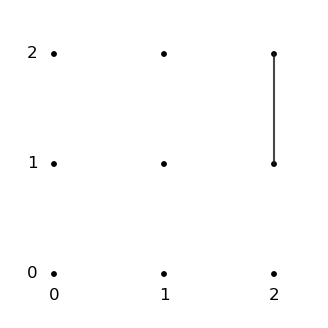

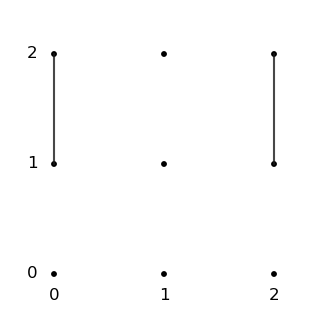

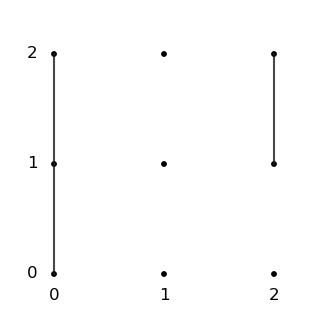

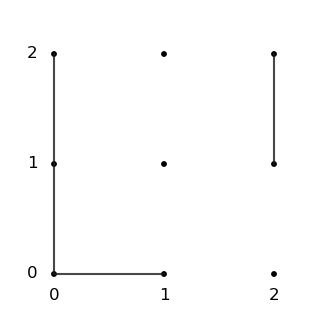

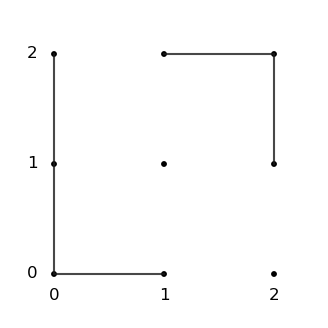

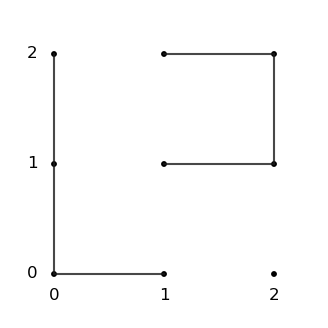

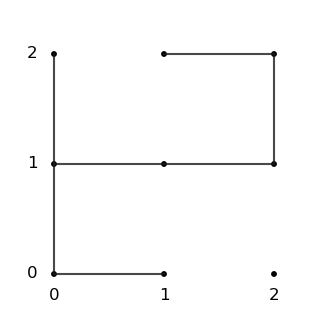

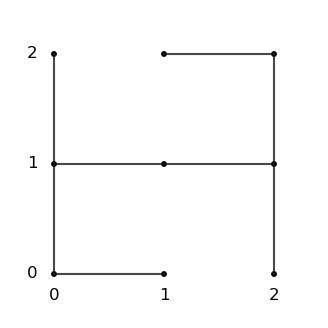

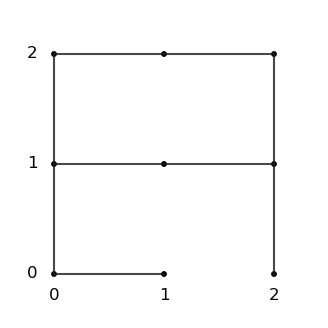

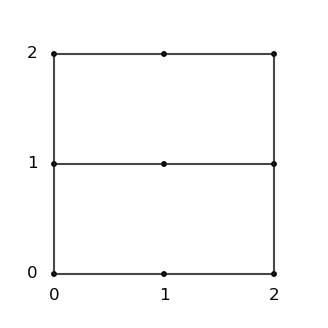

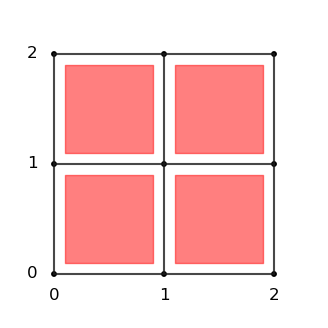

In [20]:
%matplotlib inline
from IPython.display import display

ims = [drawboard(b) for b in board_list]
display(*ims)

`board.py` contains all the helper functions you need.

`draw.py` has the `drawboard` that we have been using.

## Tips

1. My code *might* have bugs.
2. Use the validation functions. 
3. Program the simplest strategy first. 